In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pycountry
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from focal_loss import BinaryFocalLoss


## Load Data

In [63]:
dfolder = 'data/'

In [64]:
# df = pd.read_csv(dfolder + 'merged.csv')

## Preprocessing

In [65]:
# df = df[df['year'] >= 1989]

In [66]:
# df['nonstate_deaths'].fillna(0, inplace=True)
# df['onesided_deaths'].fillna(0, inplace=True)
# df['civilian_deaths'].fillna(0, inplace=True)
# df['deaths'].fillna(0, inplace=True)
# df['state_deaths'].fillna(0, inplace=True)


In [67]:
# # Define conflict column
# df['conflict'] = df['deaths'].apply(lambda x: 1 if x > 100 else 0)
# # obtian fatality cases data 
# conf=df.drop(columns='conflict')

In [68]:
# # 'year' and 'month' columns to a datetime type
# df['Date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# # columns to be filled
# fill_cols = [col for col in df.columns if 'count' in col]

# dfs = []

# # Iterate through unique 'isocode' values
# for isocode in df['isocode'].unique():
#     df_isocode = df[df['isocode'] == isocode].copy()

#     # Create a new dataframe that covers all months between the min and max 'Date' for this isocode
#     min_date = df_isocode['Date'].min()
#     max_date = df_isocode['Date'].max()
#     all_dates = pd.DataFrame(pd.date_range(min_date, max_date, freq='MS'), columns=['Date'])

#     # merge onto the existing dataframe
#     df_isocode = pd.merge(all_dates, df_isocode, on='Date', how='left')

#     df_isocode['isocode'] = isocode

#     # forward-fill and then fill any remaining NaNs with 0
#     df_isocode[fill_cols] = df_isocode[fill_cols].ffill().fillna(0)

#     # convert the 'date' back to 'year' and 'month'
#     df_isocode['year'] = df_isocode['Date'].dt.year
#     df_isocode['month'] = df_isocode['Date'].dt.month

#     # append to list
#     dfs.append(df_isocode)

# # concatenate all DataFrames in the list into a final DataFrame
# df_final = pd.concat(dfs)

# df_final.drop(columns=['Date'], inplace=True)

# # sort final dataframe by 'isocode', 'year' and 'month'
# df_final.sort_values(['year', 'month', 'isocode'], inplace=True)
# df_final.fillna(0)


In [69]:
# def get_country_name(iso_code):
#     try:
#         return pycountry.countries.get(alpha_3=iso_code).name
#     except AttributeError:
#         return None

# df_final['country'] = df_final['isocode'].apply(get_country_name)

In [70]:
# def check_month_year_sequence(group):
#     # Create the expected sequence of months and years
#     min_year, min_month = group[['year', 'month']].iloc[0] # use the first row of each group
#     max_year, max_month = group[['year', 'month']].iloc[-1] # use the last row of each group

#     expected_month_years = [(y, m) for y in range(min_year, max_year + 1) for m in range(1, 13)]
    
#     # If there is only one year in the data, filter for months within the min and max range
#     if min_year == max_year:
#         expected_month_years = [my for my in expected_month_years if min_month <= my[1] <= max_month]
#     else:
#         # If there are multiple years, adjust for the first and last years
#         expected_month_years = [my for my in expected_month_years if 
#                                 not (my[0] == min_year and my[1] < min_month) and 
#                                 not (my[0] == max_year and my[1] > max_month)]
                                
#     # Check if the sequence of month-years in the group is equal to the expected sequence
#     actual_month_years = sorted(list(zip(group['year'], group['month'])))
    
#     if actual_month_years != expected_month_years:
#         print(f"Incorrect sequence for isocode: {group['isocode'].iloc[0]}")
#         print(f"Expected: {expected_month_years}")
#         print(f"Actual: {actual_month_years}")
        
#     return actual_month_years == expected_month_years


In [71]:
# # Apply the function to each group
# is_sequence_correct = df_final.groupby('isocode').apply(check_month_year_sequence)

# # Check if the sequence of month-years is correct for all isocodes
# assert is_sequence_correct.all(), "The sequence of month-years is not correct for some isocodes"

In [72]:
# df_final['date'] = pd.to_datetime(df_final[['year', 'month']].assign(day=1))

In [73]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(15,6))
# df_final.set_index('date')['state_deaths'].plot()
# plt.title('State Deaths over Time')
# plt.xlabel('Date')
# plt.ylabel('State Deaths')
# plt.show()


In [74]:
# df_final = df_final.sort_values(['year', 'month', 'isocode'])


In [75]:
# # List of all event count columns for gov, opp and total events
# event_cols = ['count_events_{}'.format(i) for i in range(1, 21)]
# event_cols_gov = ['count_events_{}_gov'.format(i) for i in range(1, 21)]
# event_cols_opp = ['count_events_{}_opp'.format(i) for i in range(1, 21)]

# # Compute the total events for each group
# df_final['total_events'] = df_final[event_cols].sum(axis=1)
# df_final['total_events_gov'] = df_final[event_cols_gov].sum(axis=1)
# df_final['total_events_opp'] = df_final[event_cols_opp].sum(axis=1)

# # Compute the share of each type of event for each group and create new columns
# for col in event_cols:
#     df_final['share_events_{}'.format(col)] = df_final[col] / df_final['total_events']
    
# for col in event_cols_gov:
#     df_final['share_events_{}'.format(col)] = df_final[col] / df_final['total_events_gov']

# for col in event_cols_opp:
#     df_final['share_events_{}'.format(col)] = df_final[col] / df_final['total_events_opp']

# # Drop the original count_events_* columns
# df_final.drop(columns=event_cols + event_cols_gov + event_cols_opp, inplace=True)
# df_final = df_final.fillna(0)



In [76]:
# # columns to drop
# cols_to_drop = ['total_events', 'total_events_gov', 'total_events_opp',
#                 'nonstate_deaths', 'onesided_deaths', 'civilian_deaths', 'state_deaths', 'MonthYear', 'date', 'country']

# # Drop the columns
# df_final = df_final.drop(columns=cols_to_drop, axis=1)


In [77]:
# # Drop rows with missing values
# df_final = df_final.dropna()

In [78]:
# def get_country_name(iso_code):
#     try:
#         return pycountry.countries.get(alpha_3=iso_code).name
#     except AttributeError:
#         return None

# df_final['country'] = df_final['isocode'].apply(get_country_name)

In [79]:
# df_final.reset_index(drop=True, inplace=True)

## Normalizing

In [80]:
df_final = pd.read_csv(dfolder + 'preprocessed_df.csv')

In [81]:
df_final.columns

Index(['MonthYear', 'isocode', 'month', 'year', 'deaths', 'state_deaths',
       'nonstate_deaths', 'onesided_deaths', 'civilian_deaths', 'month_year',
       ...
       'civilwar', 'past6', 'past12', 'past60', 'past120', 'armedconf_since',
       'num_regions', 'Adm1_Max', 'Adm1_Mean', 'Adm1_Median'],
      dtype='object', length=110)

In [82]:
df_final

,MonthYear,isocode,month,year,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,month_year,...,civilwar,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median
0,1970-01-01 00:00:00.000198901,AFG,1,1989,693.0,693.0,0.0,0.0,0.0,1989-01-01,...,True,6.492918,6.492918,6.492918,6.492918,0,30,697.369942,592.192795,589.094457
1,1970-01-01 00:00:00.000198901,AGO,1,1989,249.0,249.0,0.0,0.0,0.0,1989-01-01,...,False,2.176669,2.176669,2.176669,2.176669,0,15,174.456311,130.394972,134.281915
2,1970-01-01 00:00:00.000198901,ALB,1,1989,0.0,0.0,0.0,0.0,0.0,1989-01-01,...,False,0.000000,0.000000,0.000000,0.000000,1,9,0.035503,0.026422,0.026422
3,1970-01-01 00:00:00.000198901,ARE,1,1989,0.0,0.0,0.0,0.0,0.0,1989-01-01,...,False,0.000000,0.000000,0.000000,0.000000,1,4,0.123984,0.123984,0.123984
4,1970-01-01 00:00:00.000198901,ARG,1,1989,0.0,0.0,0.0,0.0,0.0,1989-01-01,...,False,0.000000,0.000000,0.000000,0.000000,1,12,0.450262,0.255481,0.261398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79870,1970-01-01 00:00:00.000202305,XKX,5,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,False,0.000000,0.000000,0.000000,0.000000,412,10,0.000000,0.000000,0.000000
79871,1970-01-01 00:00:00.000202305,YEM,5,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,False,0.927789,2.416496,101.723726,162.727194,2,20,200.276596,121.436293,118.934417
79872,1970-01-01 00:00:00.000202305,ZAF,5,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,False,0.000000,0.010102,0.102890,0.108207,22,11,14.751497,12.100576,13.784257
79873,1970-01-01 00:00:00.000202305,ZMB,5,2023,0.0,0.0,0.0,0.0,0.0,2023-05-01,...,False,0.000000,0.000000,0.000000,0.000000,258,11,0.120482,0.065602,0.060748


In [83]:
df_final['country'] = df_final['Country Name']

In [84]:
# normalized the data 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_final.drop(columns=['isocode','month','year','civilwar','armedconf','Country Name', 'MonthYear', 'month_year', 'date', 'country']))

In [85]:
scaled_df=pd.DataFrame(data=scaled,columns=df_final.drop(columns=['isocode','month','year','civilwar','armedconf','Country Name', 'MonthYear', 'month_year', 'date', 'country']).columns)


In [86]:
scaled_df

,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,wb_pop,total_events,total_events_gov,total_events_opp,share_events_count_events_1,...,deaths_state_pc,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median
0,0.001327,0.027164,0.0,0.0,0.0,0.007538,0.001366,0.001812,0.004366,0.079903,...,0.000837,0.000813,0.000806,0.000800,0.000794,0.000000,0.124464,0.267389,0.297898,0.291588
1,0.000477,0.009760,0.0,0.0,0.0,0.008081,0.000350,0.000324,0.000273,0.074124,...,0.000281,0.000273,0.000270,0.000268,0.000266,0.000000,0.060086,0.066891,0.065594,0.066466
2,0.000000,0.000000,0.0,0.0,0.0,0.002266,0.000122,0.000169,0.000063,0.123077,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002421,0.034335,0.000014,0.000013,0.000013
3,0.000000,0.000000,0.0,0.0,0.0,0.001250,0.000020,0.000019,0.000000,0.116279,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002421,0.012876,0.000048,0.000062,0.000061
4,0.000000,0.000000,0.0,0.0,0.0,0.022756,0.000246,0.000608,0.000420,0.139847,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002421,0.047210,0.000173,0.000129,0.000129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79870,0.000000,0.000000,0.0,0.0,0.0,0.001246,0.000153,0.000177,0.000063,0.092308,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.997579,0.038627,0.000000,0.000000,0.000000
79871,0.000000,0.000000,0.0,0.0,0.0,0.023334,0.000793,0.000970,0.000987,0.082192,...,0.000000,0.000116,0.000300,0.012528,0.019899,0.004843,0.081545,0.076791,0.061088,0.058870
79872,0.000000,0.000000,0.0,0.0,0.0,0.042034,0.010216,0.010367,0.002666,0.151882,...,0.000000,0.000000,0.000001,0.000013,0.000013,0.053269,0.042918,0.005656,0.006087,0.006823
79873,0.000000,0.000000,0.0,0.0,0.0,0.013769,0.000620,0.000917,0.000042,0.146992,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.624697,0.042918,0.000046,0.000033,0.000030


In [87]:
conf=df_final.copy()
conf[scaled_df.columns]=np.array(scaled_df)
conf['country']=list(conf.country)
conf=conf.set_index(['isocode','month','year'])
conf

,,,MonthYear,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,month_year,Country Name,wb_pop,date,...,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median,country
isocode,month,year,,,,,,,,,,,,,,,,,,,,,
AFG,1,1989,1970-01-01 00:00:00.000198901,0.001327,0.027164,0.0,0.0,0.0,1989-01-01,Afghanistan,0.007538,1989-01-01,...,0.000813,0.000806,0.000800,0.000794,0.000000,0.124464,0.267389,0.297898,0.291588,Afghanistan
AGO,1,1989,1970-01-01 00:00:00.000198901,0.000477,0.009760,0.0,0.0,0.0,1989-01-01,Angola,0.008081,1989-01-01,...,0.000273,0.000270,0.000268,0.000266,0.000000,0.060086,0.066891,0.065594,0.066466,Angola
ALB,1,1989,1970-01-01 00:00:00.000198901,0.000000,0.000000,0.0,0.0,0.0,1989-01-01,Albania,0.002266,1989-01-01,...,0.000000,0.000000,0.000000,0.000000,0.002421,0.034335,0.000014,0.000013,0.000013,Albania
ARE,1,1989,1970-01-01 00:00:00.000198901,0.000000,0.000000,0.0,0.0,0.0,1989-01-01,United Arab Emirates,0.001250,1989-01-01,...,0.000000,0.000000,0.000000,0.000000,0.002421,0.012876,0.000048,0.000062,0.000061,United Arab Emirates
ARG,1,1989,1970-01-01 00:00:00.000198901,0.000000,0.000000,0.0,0.0,0.0,1989-01-01,Argentina,0.022756,1989-01-01,...,0.000000,0.000000,0.000000,0.000000,0.002421,0.047210,0.000173,0.000129,0.000129,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XKX,5,2023,1970-01-01 00:00:00.000202305,0.000000,0.000000,0.0,0.0,0.0,2023-05-01,Kosovo,0.001246,2023-05-01,...,0.000000,0.000000,0.000000,0.000000,0.997579,0.038627,0.000000,0.000000,0.000000,Kosovo
YEM,5,2023,1970-01-01 00:00:00.000202305,0.000000,0.000000,0.0,0.0,0.0,2023-05-01,"Yemen, Rep.",0.023334,2023-05-01,...,0.000116,0.000300,0.012528,0.019899,0.004843,0.081545,0.076791,0.061088,0.058870,"Yemen, Rep."
ZAF,5,2023,1970-01-01 00:00:00.000202305,0.000000,0.000000,0.0,0.0,0.0,2023-05-01,South Africa,0.042034,2023-05-01,...,0.000000,0.000001,0.000013,0.000013,0.053269,0.042918,0.005656,0.006087,0.006823,South Africa


In [88]:
top_10_countries=pd.DataFrame(conf.groupby('country')['armedconf'].sum()).sort_values(by='armedconf',ascending=False).reset_index()
top_10_country_names=top_10_countries.country[:11]

In [89]:
conf.drop(['civilwar', 'Country Name', 'MonthYear', 'month_year', 'date', 'state_deaths','nonstate_deaths','onesided_deaths','civilian_deaths'], axis=1, inplace=True)


In [90]:
conf['armedconf'] = conf['armedconf'].astype(int)

### Train Test Split

In [91]:
def train_test_split(data):
    size=int(len(data)*0.8)
    # for train data will be collected from each country's data which index is from 0-size (80%)
    x_train =data.drop(columns=['armedconf']).iloc[0:size] 
    # for test data will be collected from each country's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['armedconf']).iloc[size:]
    y_train=data['armedconf'].iloc[0:size] 
    y_test=data['armedconf'].iloc[size:] 
    return x_train, x_test,y_train,y_test

In [92]:
country=list(set(conf.country))
# loop each station and collect train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(country)):
    data=conf[conf['country']==country[i]]
    x_train, x_test,y_train,y_test=train_test_split(data)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [93]:
# concat each train data from each station 
X_train=pd.concat(X_train)
Y_train=pd.DataFrame(pd.concat(Y_train))
# concat each test data from each station 
X_test=pd.concat(X_test)
Y_test=pd.DataFrame(pd.concat(Y_test))

## Model

In [94]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create the reshape function
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except PM2.5
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)
    # split into train and test sets
    train= reframed_train.values
    test=reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test

In [95]:
encoder = LabelEncoder()
#combine x train and y train as train data 
train_data=pd.DataFrame()
train_data[X_train.columns]=X_train
train_data[Y_train.columns]=Y_train
train_data['country']= encoder.fit_transform(train_data['country'])
#combine x test and y test as test data 
test_data=pd.DataFrame()
test_data[X_test.columns]=X_test
test_data[Y_test.columns]=Y_test
test_data['country']= encoder.fit_transform(test_data['country'])
test_data.shape

(16055, 99)

In [96]:
train_data

deaths    wb_pop  total_events  total_events_gov  \
isocode month year                                                     
EGY     1     1989     0.0  0.039466      0.000515          0.000532   
        2     1989     0.0  0.039466      0.000866          0.001270   
        3     1989     0.0  0.039466      0.000587          0.000760   
        4     1989     0.0  0.039466      0.000522          0.000799   
        5     1989     0.0  0.039466      0.000685          0.000726   
...                    ...       ...           ...               ...   
MAC     2     2016     0.0  0.000425      0.000359          0.000314   
        3     2016     0.0  0.000425      0.000410          0.000358   
        4     2016     0.0  0.000425      0.000306          0.000271   
        5     2016     0.0  0.000425      0.000298          0.000314   
        6     2016     0.0  0.000425      0.000368          0.000370   

                    total_events_opp  share_events_count_events_1  \
isocode month year                                                  
EGY     1     1989          0.000189                     0.110092   
        2     1989          0.000084                     0.066558   
        3     1989          0.000336                     0.078037   
        4     1989          0.000378                     0.097649   
        5     1989          0.000189                     0.080000   
...                              ...                          ...   
MAC     2     2016          0.000042                     0.142105   
        3     2016          0.000021                     0.162255   
        4     2016          0.000042                     0.192901   
        5     2016          0.000084                     0.123613   
        6     2016          0.000084                     0.121951   

                    share_events_count_events_2  share_events_count_events_3  \
isocode month year                                                             
EGY     1     1989                     0.039450                     0.074312   
        2     1989                     0.045281                     0.132570   
        3     1989                     0.059533                     0.104586   
        4     1989                     0.064195                     0.075045   
        5     1989                     0.051724                     0.075862   
...                                         ...                          ...   
MAC     2     2016                     0.071053                     0.082895   
        3     2016                     0.080552                     0.087457   
        4     2016                     0.086420                     0.086420   
        5     2016                     0.068146                     0.083994   
        6     2016                     0.087291                     0.077022   

                    share_events_count_events_4  share_events_count_events_5  \
isocode month year                                                             
EGY     1     1989                     0.496330                     0.101835   
        2     1989                     0.544463                     0.070376   
        3     1989                     0.413516                     0.151247   
        4     1989                     0.430380                     0.092224   
        5     1989                     0.386207                     0.191724   
...                                         ...                          ...   
MAC     2     2016                     0.357895                     0.100000   
        3     2016                     0.228999                     0.097814   
        4     2016                     0.277778                     0.078704   
        5     2016                     0.331220                     0.112520   
        6     2016                     0.305520                     0.083440   

                    ...  past12  past60  past120  armedconf_since  \
isocode month year  ...           

In [97]:
x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)

In [98]:
x_test.shape

(16054, 1, 197)

In [99]:
x_train.shape

(63819, 1, 197)

In [100]:
from tensorflow.keras import metrics
from sklearn.utils.class_weight import compute_sample_weight

# Compute class weights
class_weights = compute_sample_weight(class_weight='balanced', y=y_train)

class_weights = dict(enumerate(class_weights))

# design network for confirmed cases data 
model = Sequential()
model.add(LSTM(60, input_shape=(x_train.shape[1], x_train.shape[2])))  # Single LSTM layer with 60 neurons
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Output layer

loss = BinaryFocalLoss(gamma=2., pos_weight=3)  # Increase gamma for more focus on hard to classify instances
model.compile(loss=loss, optimizer=Adam(learning_rate=0.001), metrics=['accuracy', metrics.Recall()])

# fit network with class weights for handling imbalance
history = model.fit(x_train, y_train, epochs=30, batch_size=50, class_weight=class_weights, verbose=1, shuffle=False)


Epoch 1/30


2023-06-20 09:42:33.013864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-20 09:42:33.211827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   1/1277 [..............................] - ETA: 25:10 - loss: 0.1307 - accuracy: 0.2600 - recall_1: 1.0000

2023-06-20 09:42:33.521966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1277/1277 [==============================] - 17s 12ms/step - loss: 0.0930 - accuracy: 0.8986 - recall_1: 0.0746
Epoch 2/30
1277/1277 [==============================] - 15s 12ms/step - loss: 0.0860 - accuracy: 0.8969 - recall_1: 0.1837
Epoch 3/30
1277/1277 [==============================] - 15s 12ms/step - loss: 0.0810 - accuracy: 0.8907 - recall_1: 0.1854
Epoch 4/30
1277/1277 [==============================] - 17s 13ms/step - loss: 0.0755 - accuracy: 0.8850 - recall_1: 0.2638
Epoch 5/30
1277/1277 [==============================] - 17s 13ms/step - loss: 0.0660 - accuracy: 0.8707 - recall_1: 0.3781
Epoch 6/30
1277/1277 [==============================] - 16s 13ms/step - loss: 0.0584 - accuracy: 0.8976 - recall_1: 0.5093
Epoch 7/30
1277/1277 [==============================] - 16s 12ms/step - loss: 0.0516 - accuracy: 0.9043 - recall_1: 0.6093
Epoch 8/30
1277/1277 [==============================] - 17s 13ms/step - loss: 0.0466 - accuracy: 0.9124 - recall_1: 0.6812
Epoch 9/30
1277/1277 [=====

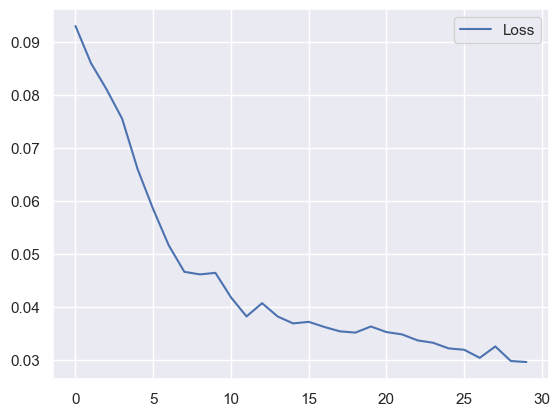

In [101]:
# plot history
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

In [102]:
y_hat = model.predict(x_test)

2023-06-20 09:50:15.862506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-20 09:50:15.928624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


502/502 [==============================] - 2s 3ms/step


In [103]:
y_hat.shape,y_test.shape


((16054, 1), (16054,))

In [104]:
#  y_test prediction has one month lag so we need re-match the date 
len([i[0] for i in y_hat][1:]),len(y_test[:-1])  


(16053, 16053)

In [105]:
pa = pd.DataFrame()
pa['Month'] = X_test.reset_index().month.iloc[1:-1]
pa['Year'] = X_test.reset_index().year.iloc[1:-1]
pa['Prediction'] = [i[0] for i in y_hat][1:]
pa['Actual Values'] = y_test[:-1]
pa.head()


,Month,Year,Prediction,Actual Values
1,8,2016,0.407537,0.0
2,9,2016,0.478703,0.0
3,10,2016,0.654148,1.0
4,11,2016,0.479655,0.0
5,12,2016,0.453518,0.0


In [106]:
pa['Actual Values'].sum()

1582.0

## Interpretation

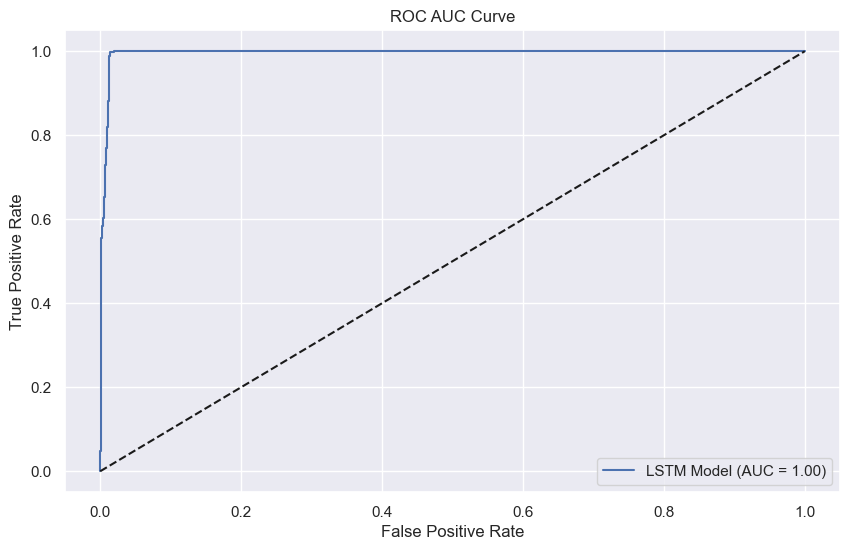

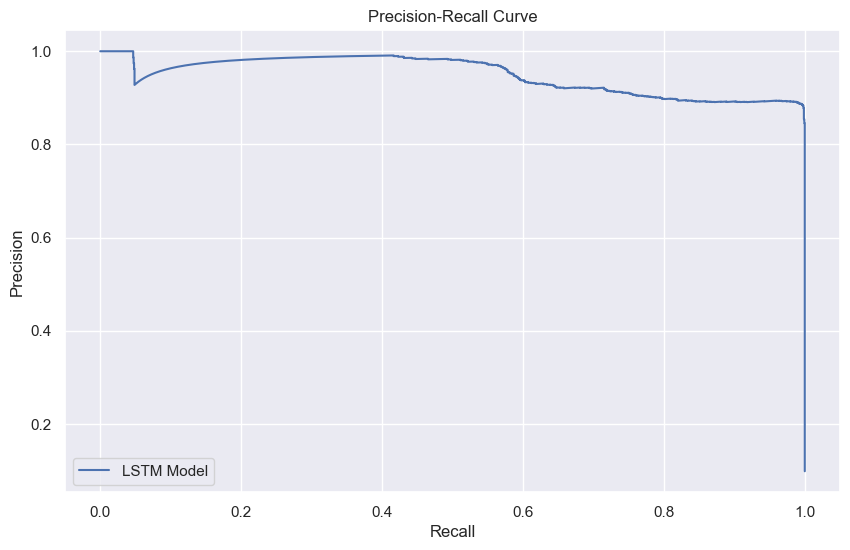

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc


y_true = pa['Actual Values'].values
y_pred = pa['Prediction'].values


# Calculate ROC AUC score
roc_auc = roc_auc_score(y_true, y_pred)

# Calculate Precision and Recall scores
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Plot ROC AUC curve
plt.figure(figsize=(10, 6))
plt.plot(*roc_curve(y_true, y_pred)[:2], label='LSTM Model (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='LSTM Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [108]:
thresholds

array([0.00273991, 0.00276337, 0.00277063, ..., 0.9805414 , 0.9875929 ,
       0.9890581 ], dtype=float32)

In [109]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# classes
y_pred_classes = (pa['Prediction'].values > 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(pa['Actual Values'].values, y_pred_classes))

print("\nClassification Report:\n", classification_report(pa['Actual Values'].values, y_pred_classes))

roc_auc_minority = roc_auc_score(pa['Actual Values'].values == 1, y_pred_classes)
print("\nROC AUC for minority class:", roc_auc_minority)

Confusion Matrix:
 [[14308   163]
 [  231  1351]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     14471
         1.0       0.89      0.85      0.87      1582

    accuracy                           0.98     16053
   macro avg       0.94      0.92      0.93     16053
weighted avg       0.98      0.98      0.98     16053


ROC AUC for minority class: 0.921359196880181


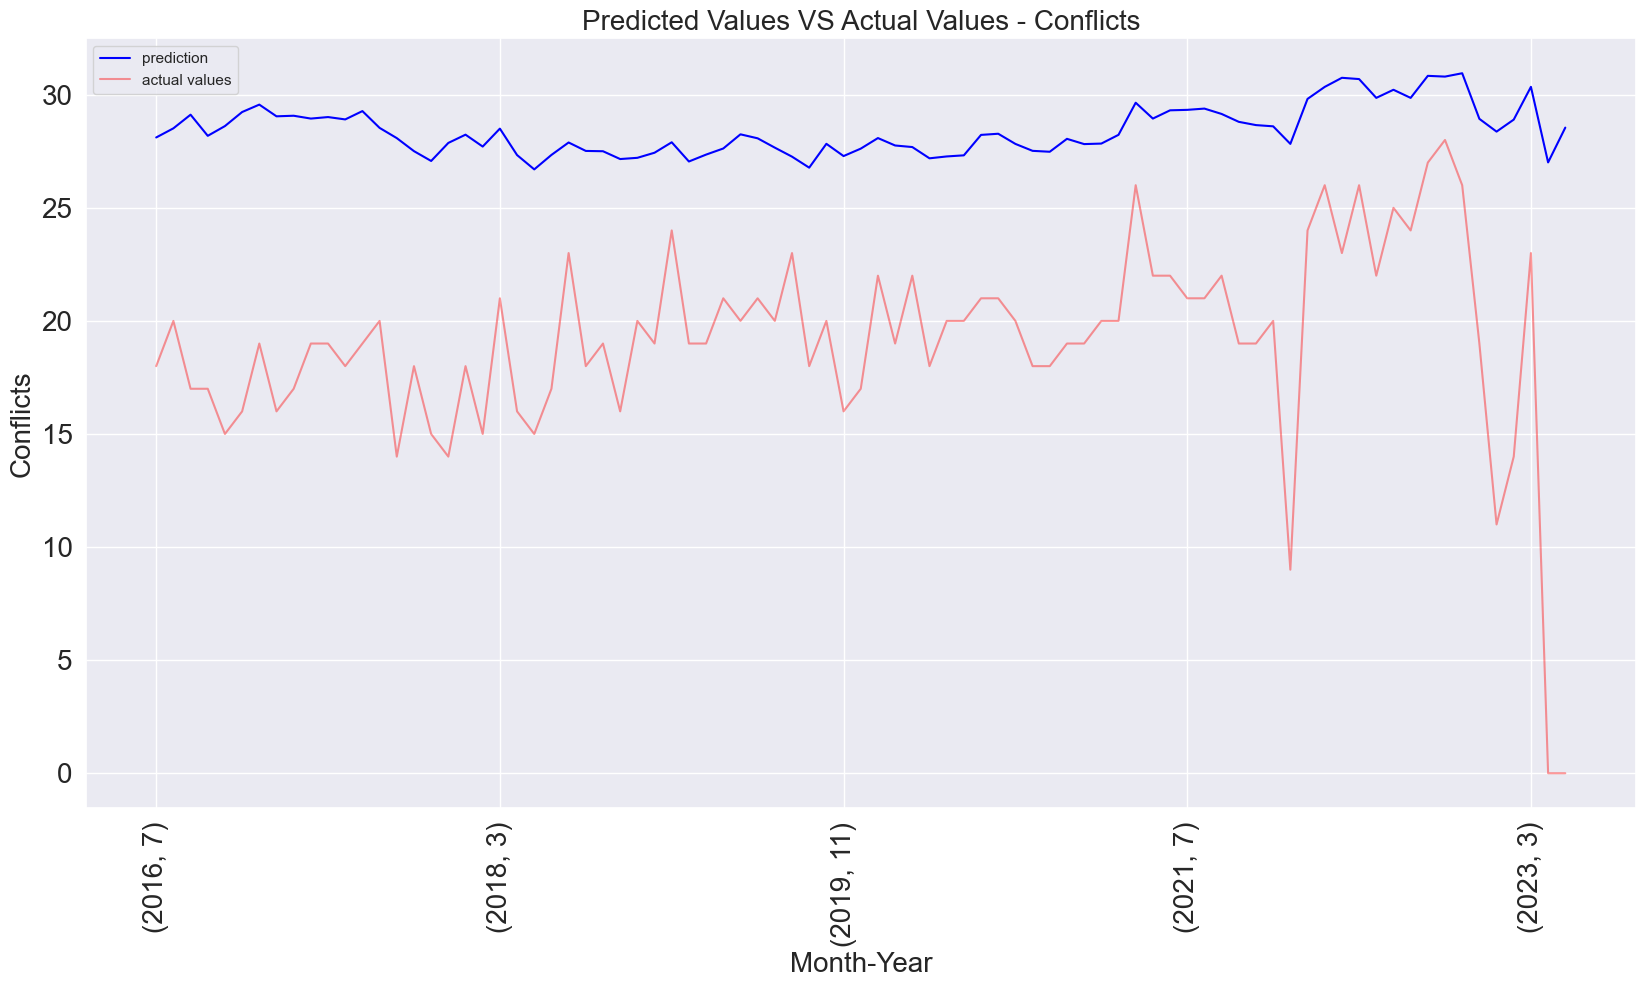

In [110]:
plt.figure(figsize=(20,10))
pa.groupby(['Year', 'Month'])['Prediction'].sum().plot(kind='line', label='prediction', color='blue', alpha=1)
pa.groupby(['Year', 'Month'])['Actual Values'].sum().plot(kind='line', label='actual values', color='red', alpha=0.4)
plt.xticks(rotation=90, size=20)
plt.yticks(size=20)

plt.ylabel('Conflicts', fontsize=20)
plt.xlabel('Month-Year', fontsize=20)
plt.title('Predicted Values VS Actual Values - Conflicts', fontsize=20)
plt.legend()


In [111]:
from sklearn.metrics import mean_squared_error
def RMSE(actual,prediction):
    rmse = np.sqrt(mean_squared_error(actual,prediction))
    return rmse

In [112]:
print(RMSE(y_test[:-1],[i[0] for i in y_hat][1:]))

0.20175316768560309


In [113]:
def normalization_train_test_split(country):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(country.drop(columns=['isocode','civilwar','armedconf','Country Name', 'MonthYear', 'month_year', 'date', 'country']))
    # create datefrane fir scaled data
    scaled_df=pd.DataFrame(data=scaled,columns=country.drop(columns=['isocode','civilwar','armedconf','Country Name', 'MonthYear', 'month_year', 'date', 'country']).columns)
    scaled_df['armedconf']=list(country.armedconf)
    X_train, X_test,Y_train,Y_test=train_test_split(scaled_df)
    #combine x train and y train as train data 
    train_data=pd.DataFrame()
    train_data[X_train.columns]=X_train
    train_data['armedconf']=Y_train
    #combine x test and y test as test data 
    test_data=pd.DataFrame()
    test_data[X_test.columns]=X_test
    test_data['armedconf']=Y_test

    # using the function to obtian reshaped x_train,x_test,y_train,y_test
    x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)
    return x_train, x_test,y_train,y_test

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/176966479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country['armedconf'] = df_final['armedconf'].astype(int)
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[X_train.columns]=X_train
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

3/3 [==============================] - 0s 11ms/step


2023-06-20 09:50:23.817852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-20 09:50:23.866598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Afghanistan - RMSE: 0.4966670894175095


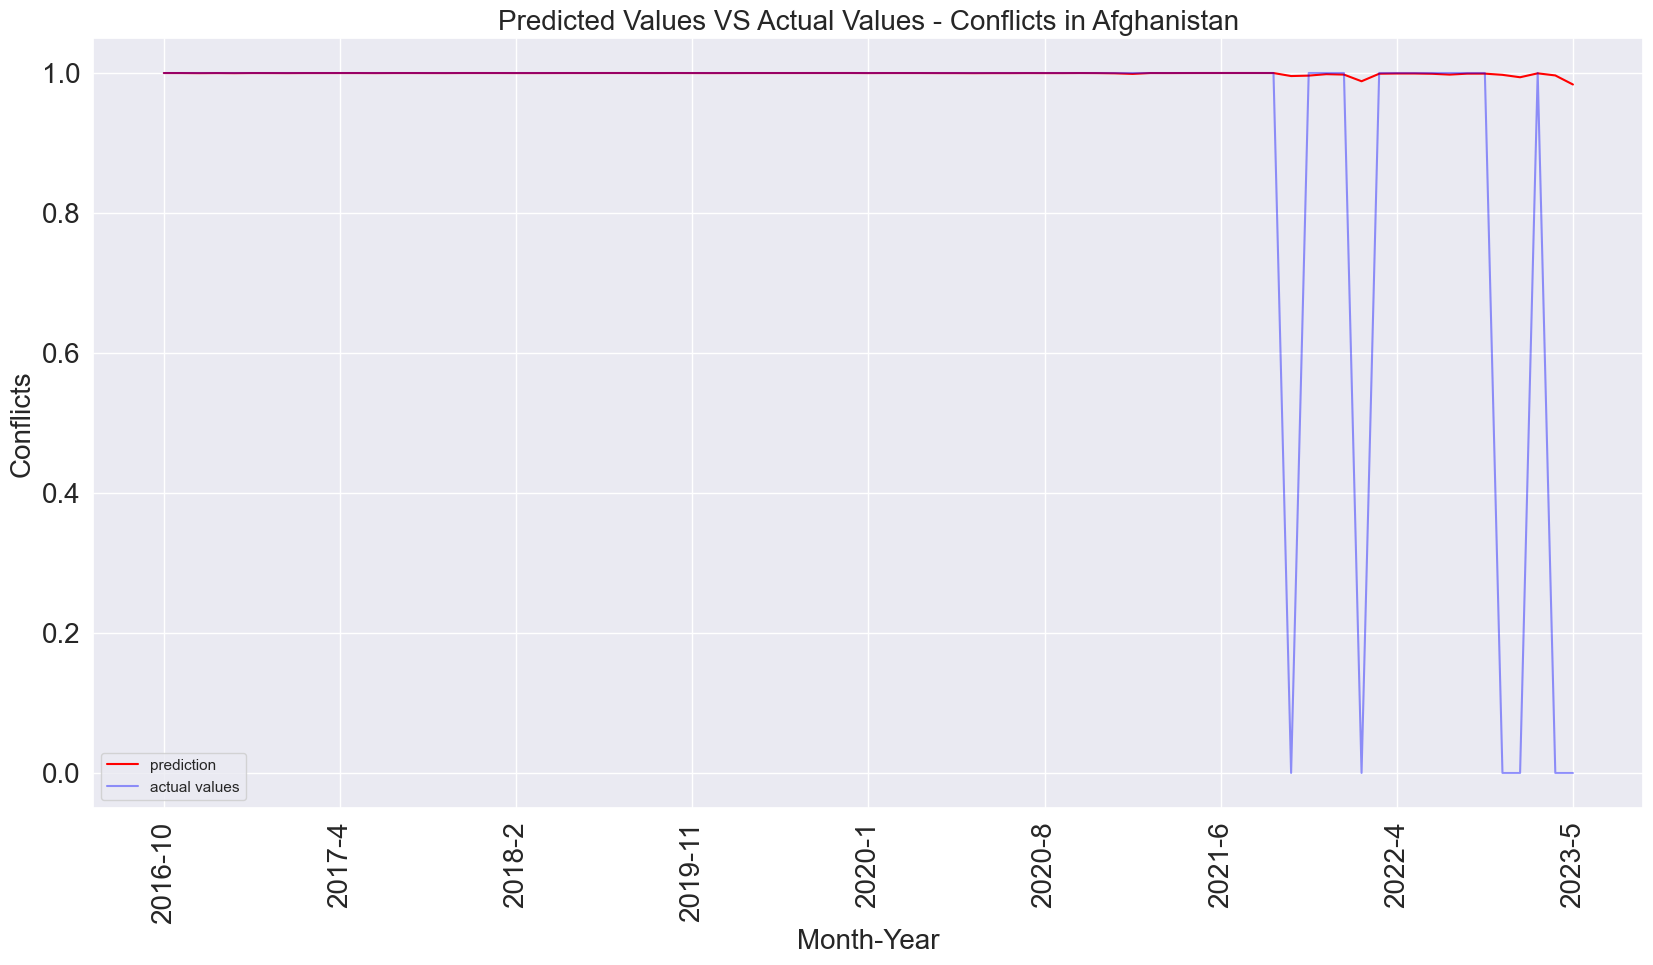

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/176966479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country['armedconf'] = df_final['armedconf'].astype(int)
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[X_train.columns]=X_train
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

3/3 [==============================] - 0s 18ms/step


2023-06-20 09:50:29.517422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-20 09:50:29.569032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Somalia - RMSE: 0.39316534887873233


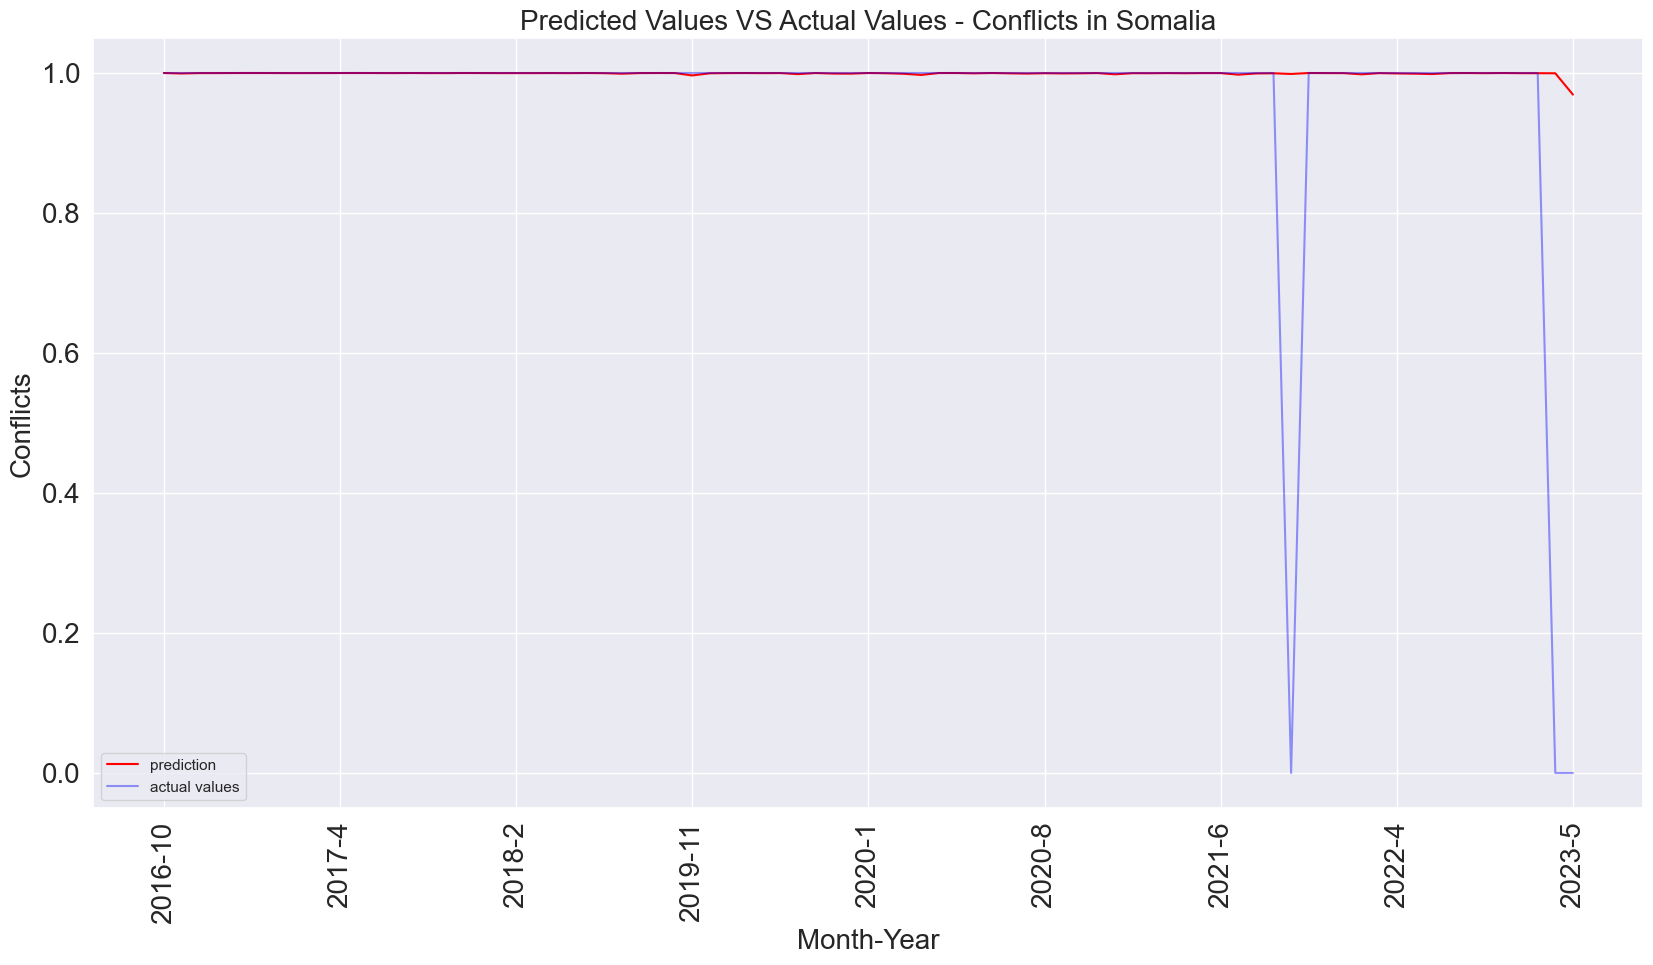

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/176966479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country['armedconf'] = df_final['armedconf'].astype(int)
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[X_train.columns]=X_train
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

3/3 [==============================] - 0s 15ms/step


2023-06-20 09:50:35.293654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-20 09:50:35.342509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Sudan - RMSE: 0.7238761684859208


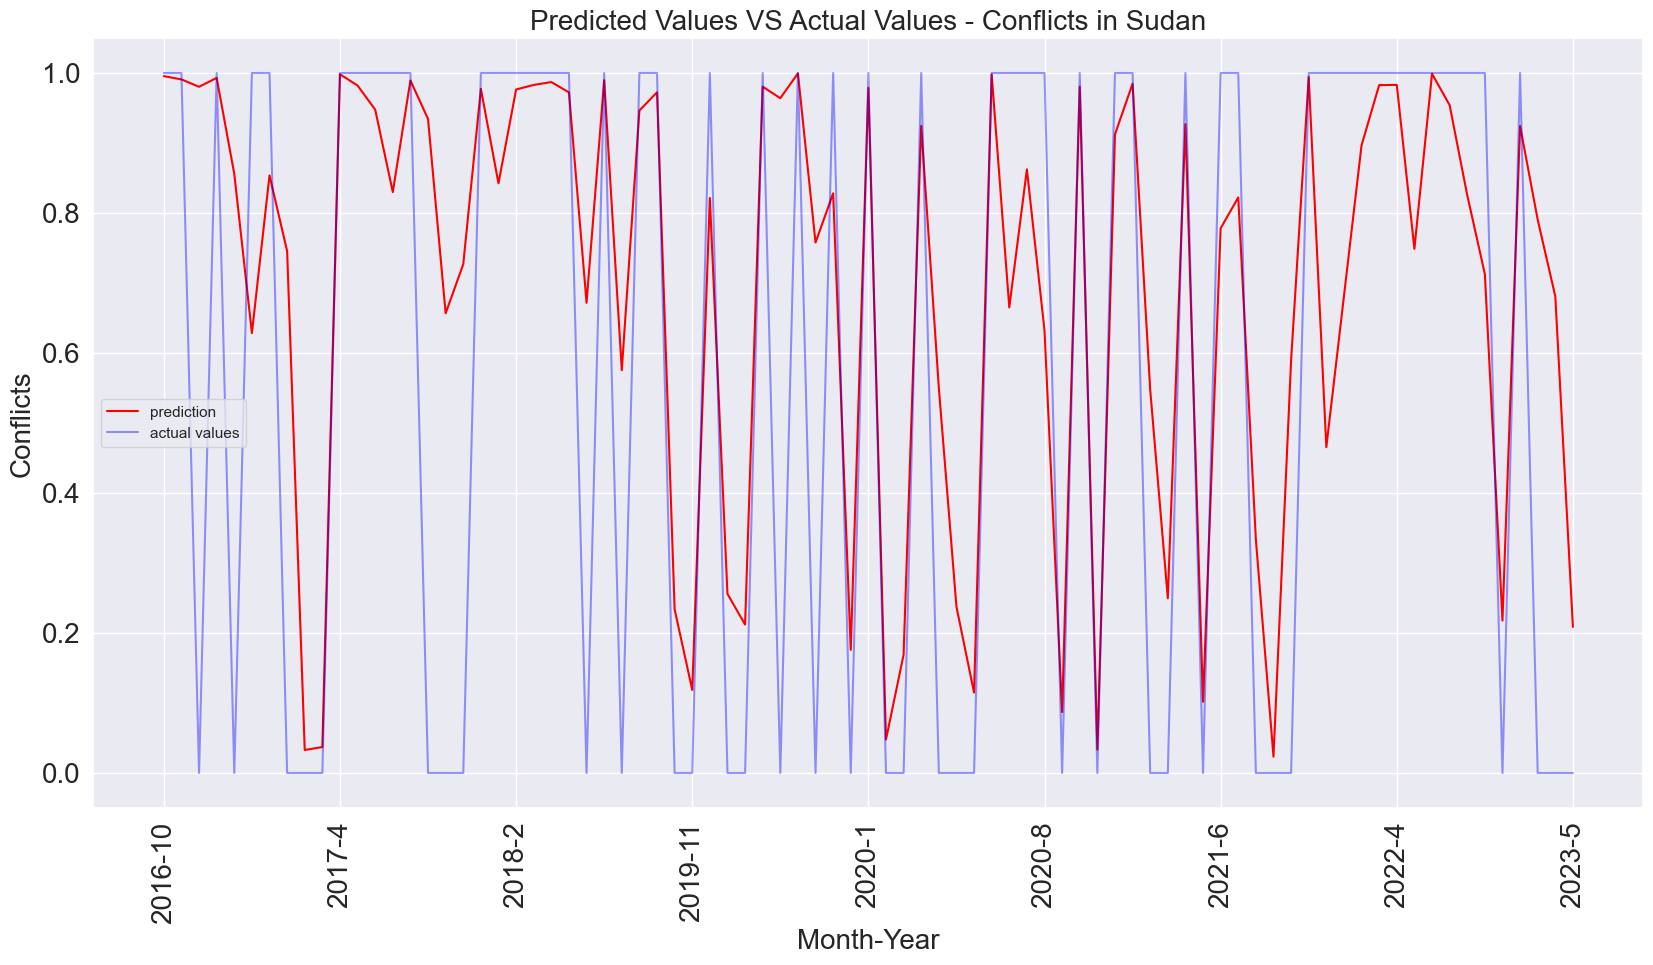

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/176966479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country['armedconf'] = df_final['armedconf'].astype(int)
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[X_train.columns]=X_train
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

3/3 [==============================] - 0s 16ms/step


2023-06-20 09:50:41.578660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-20 09:50:41.629739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Iraq - RMSE: 0.4704496240083644


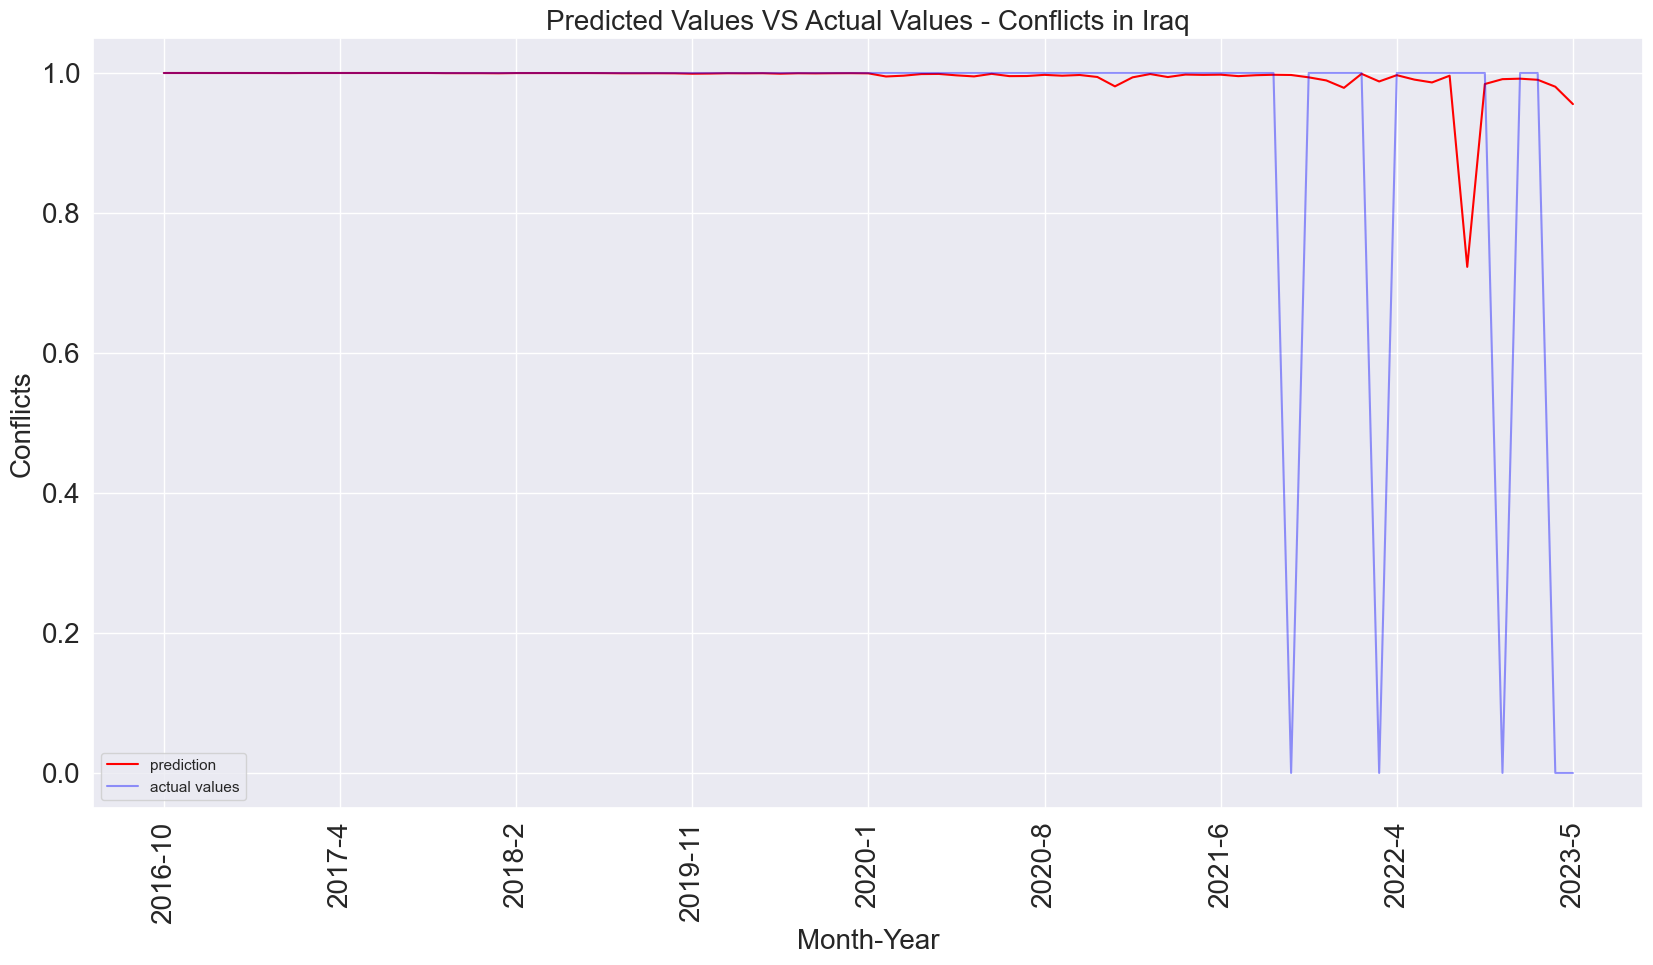

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/176966479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country['armedconf'] = df_final['armedconf'].astype(int)
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[X_train.columns]=X_train
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

3/3 [==============================] - 0s 9ms/step


2023-06-20 09:50:48.437944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-20 09:50:48.487963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Congo, Dem. Rep. - RMSE: 0.5046414742852681


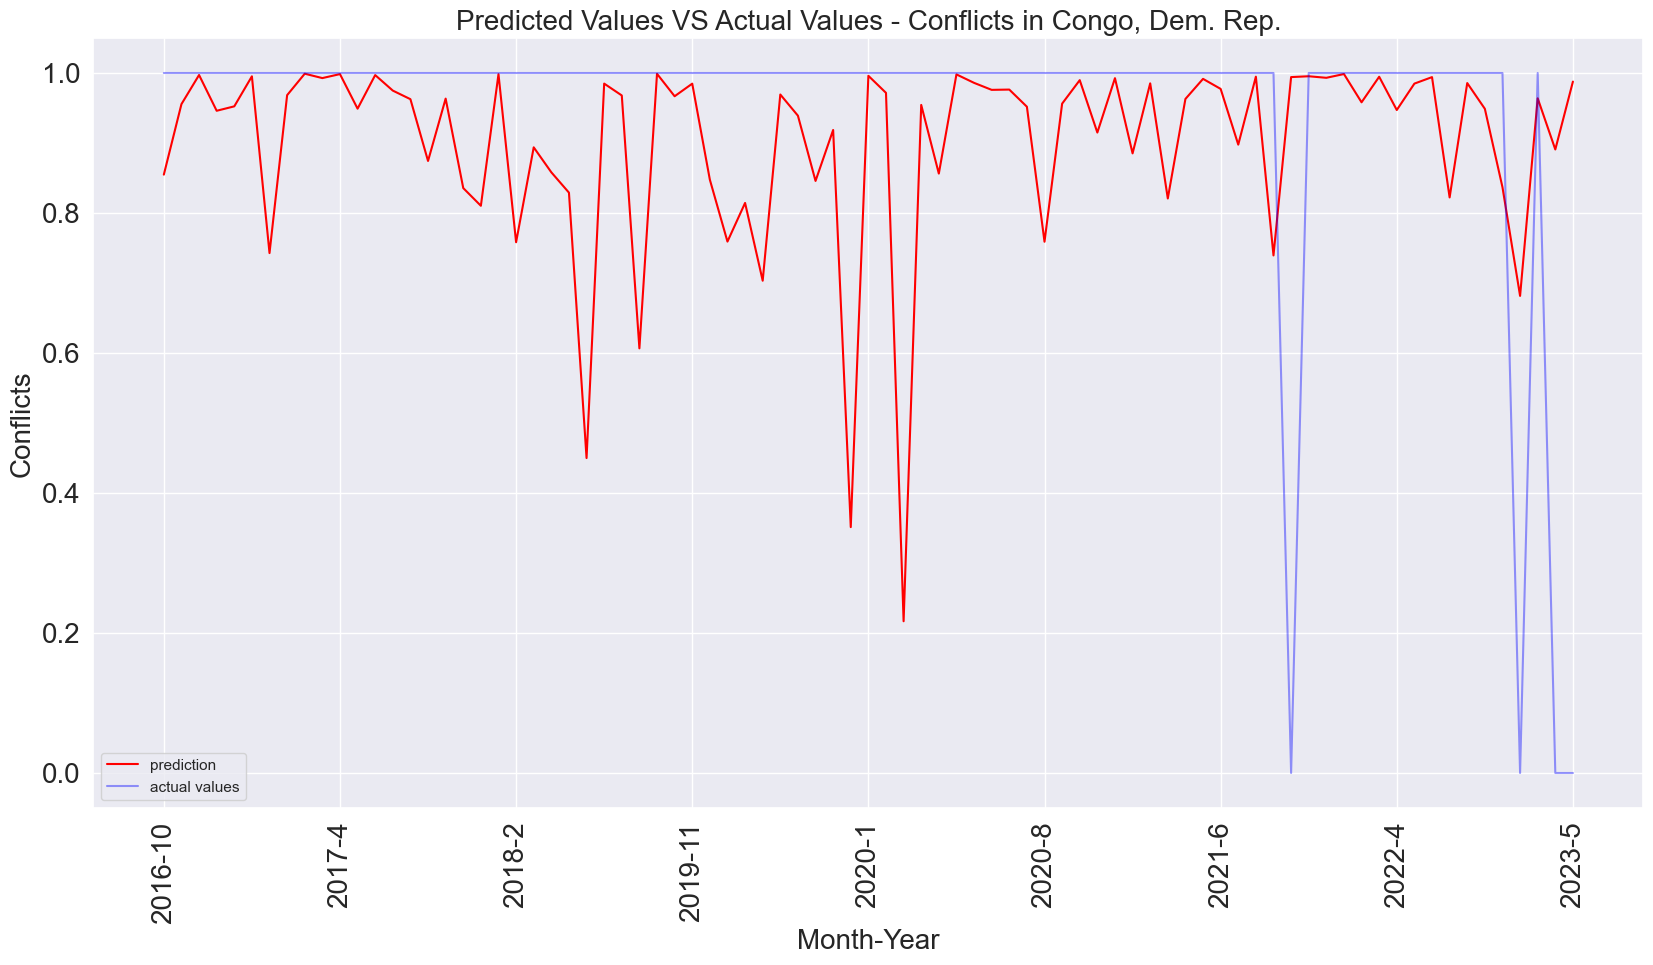

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/176966479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country['armedconf'] = df_final['armedconf'].astype(int)
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[X_train.columns]=X_train
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

3/3 [==============================] - 0s 14ms/step


2023-06-20 09:50:54.203117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-20 09:50:54.252105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Colombia - RMSE: 0.6412608196959176


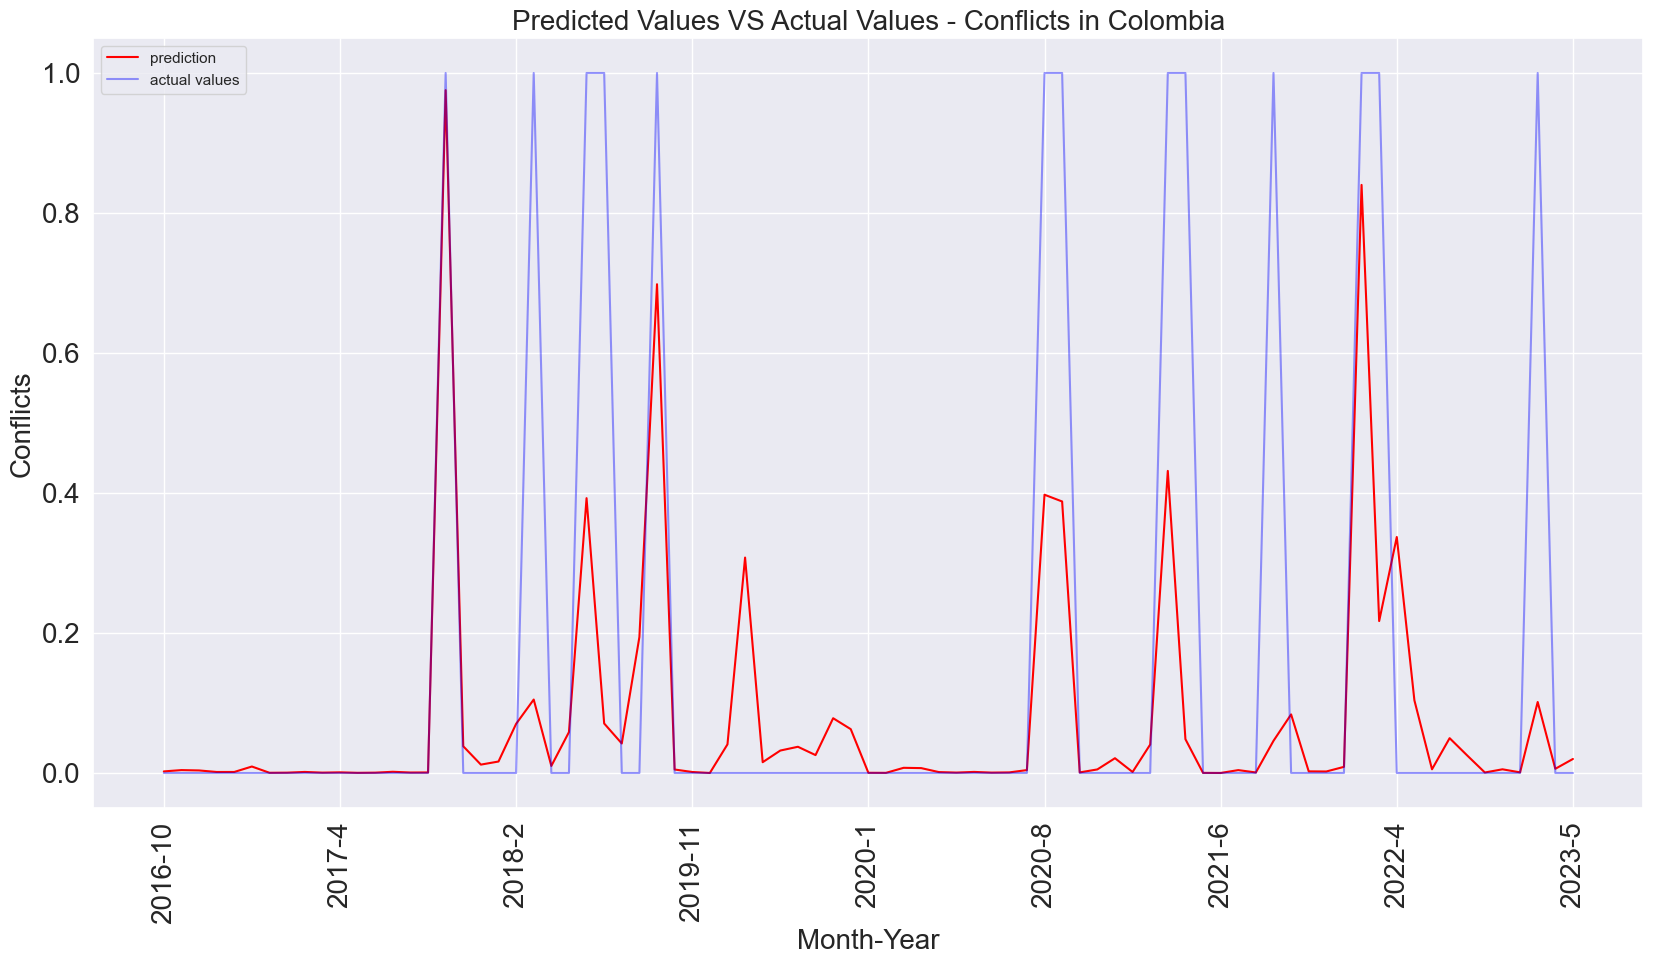

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/176966479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country['armedconf'] = df_final['armedconf'].astype(int)
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[X_train.columns]=X_train
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

3/3 [==============================] - 0s 11ms/step


2023-06-20 09:51:00.160149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-20 09:51:00.208825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Israel - RMSE: 0.6839373455455235


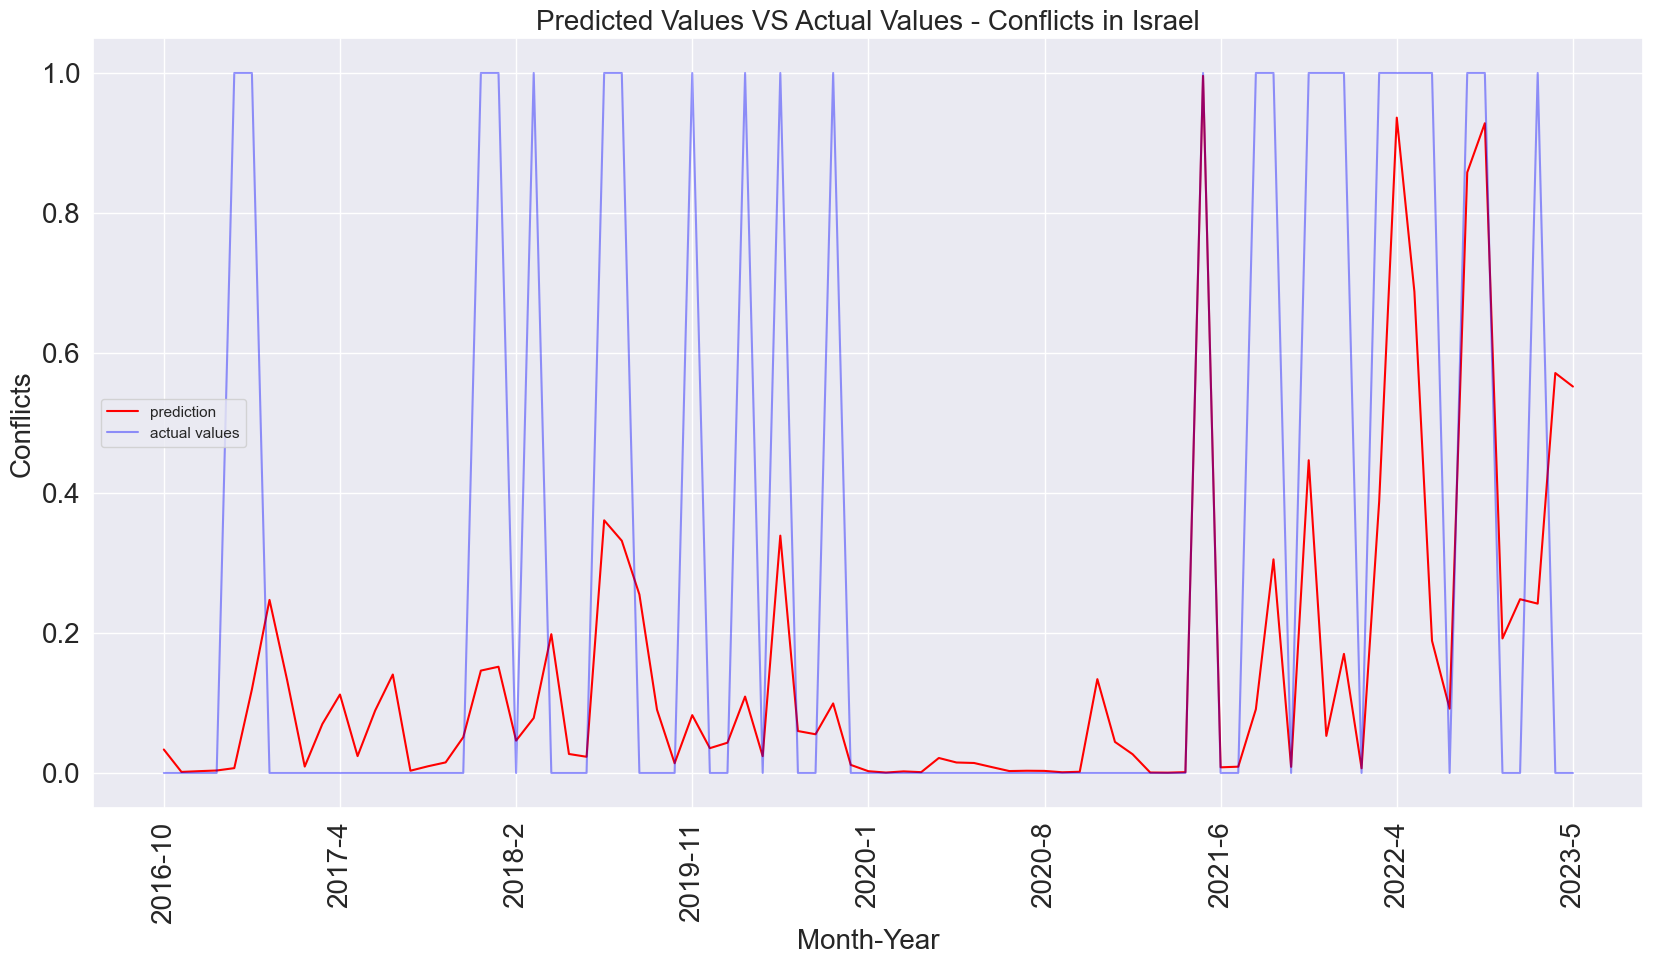

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/176966479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country['armedconf'] = df_final['armedconf'].astype(int)
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[X_train.columns]=X_train
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

3/3 [==============================] - 0s 15ms/step


2023-06-20 09:51:06.061070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-20 09:51:06.109580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Algeria - RMSE: 0.31581427483222657


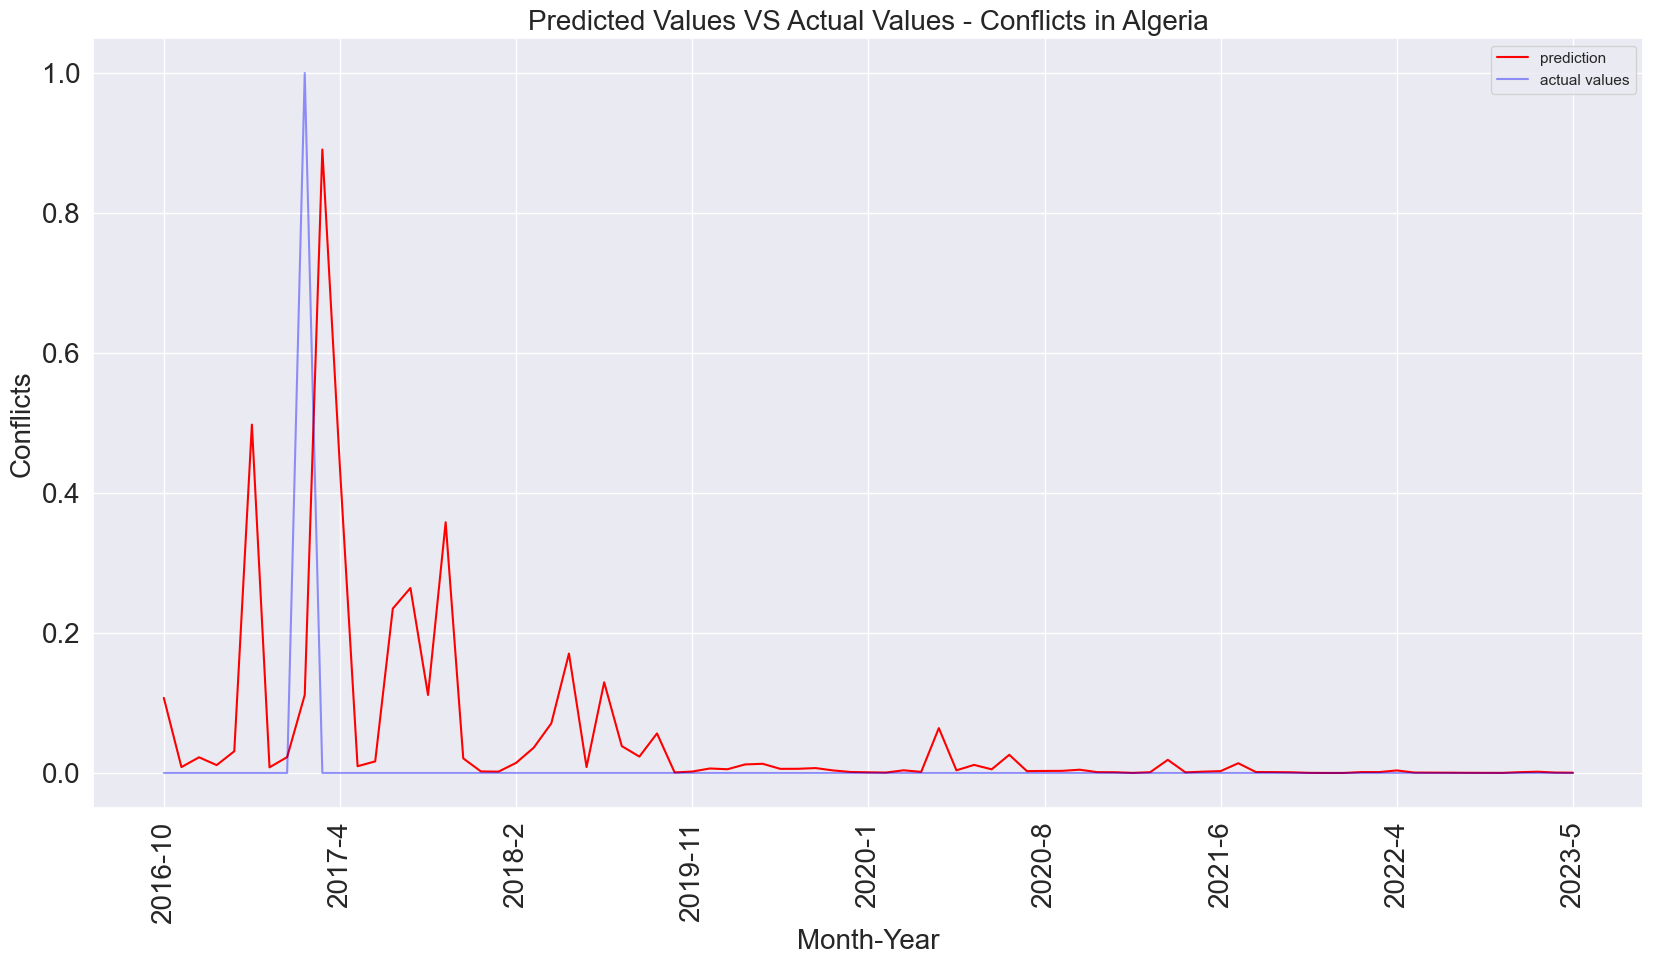

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/176966479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country['armedconf'] = df_final['armedconf'].astype(int)
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[X_train.columns]=X_train
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

3/3 [==============================] - 0s 20ms/step


2023-06-20 09:51:12.937987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-20 09:51:12.987721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Burundi - RMSE: 0.7198071741503073


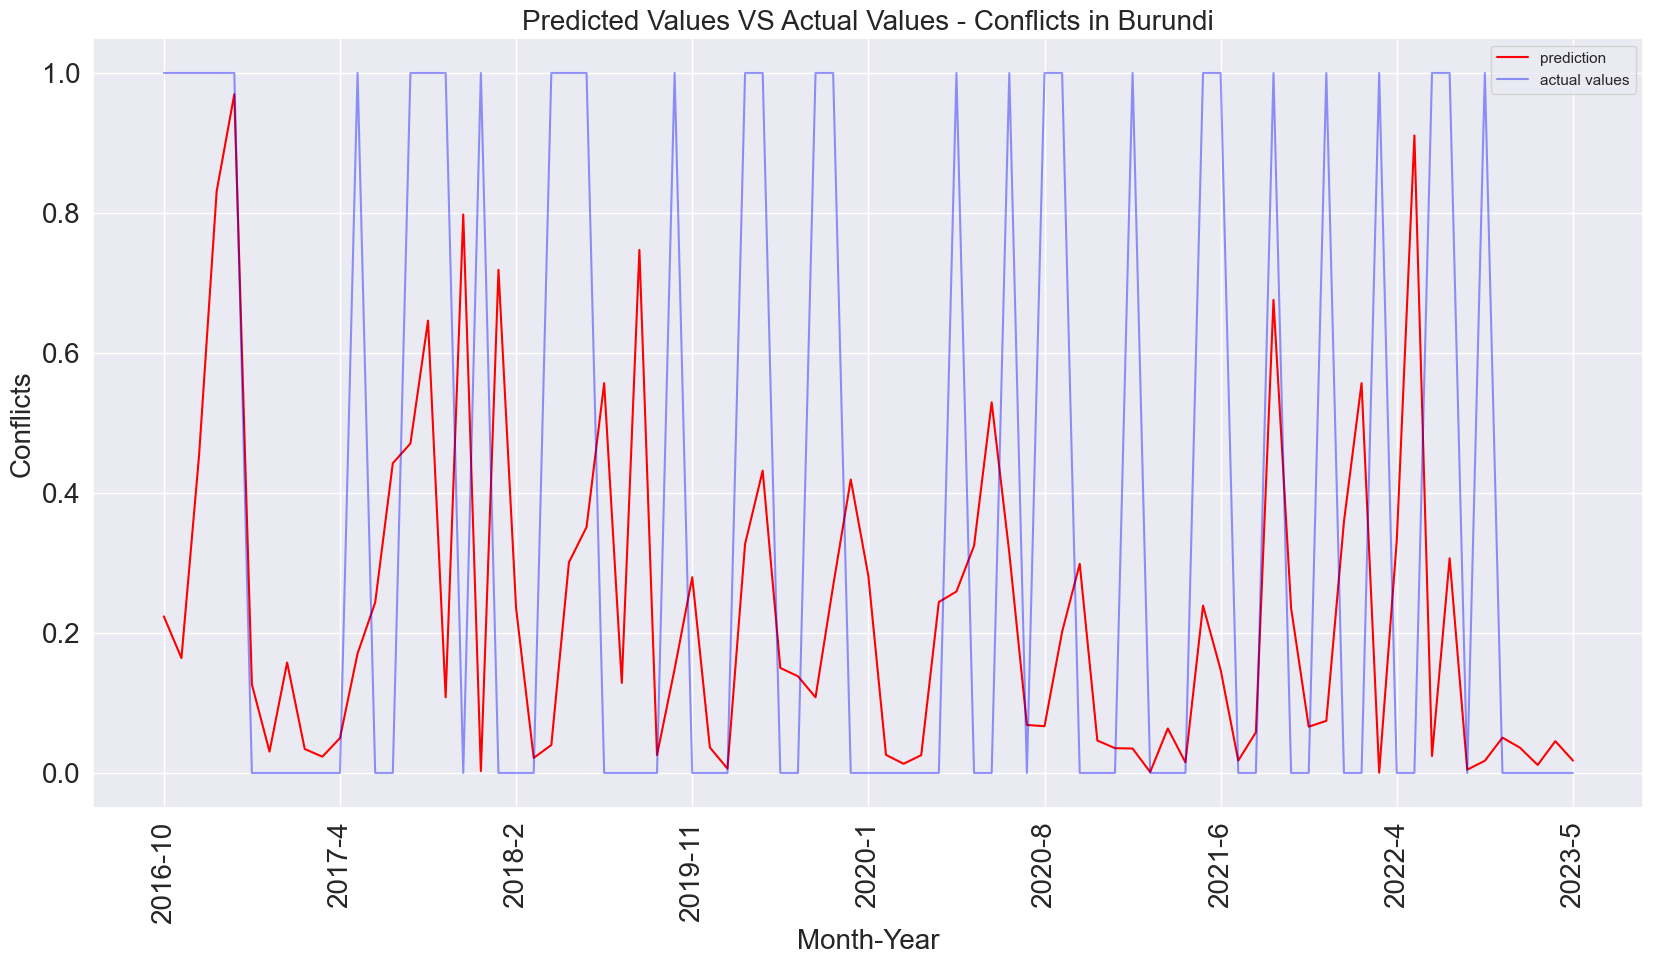

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/176966479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country['armedconf'] = df_final['armedconf'].astype(int)
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[X_train.columns]=X_train
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

3/3 [==============================] - 0s 13ms/step


2023-06-20 09:51:18.982005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-20 09:51:19.030742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Sri Lanka - RMSE: 0.3172013573536128


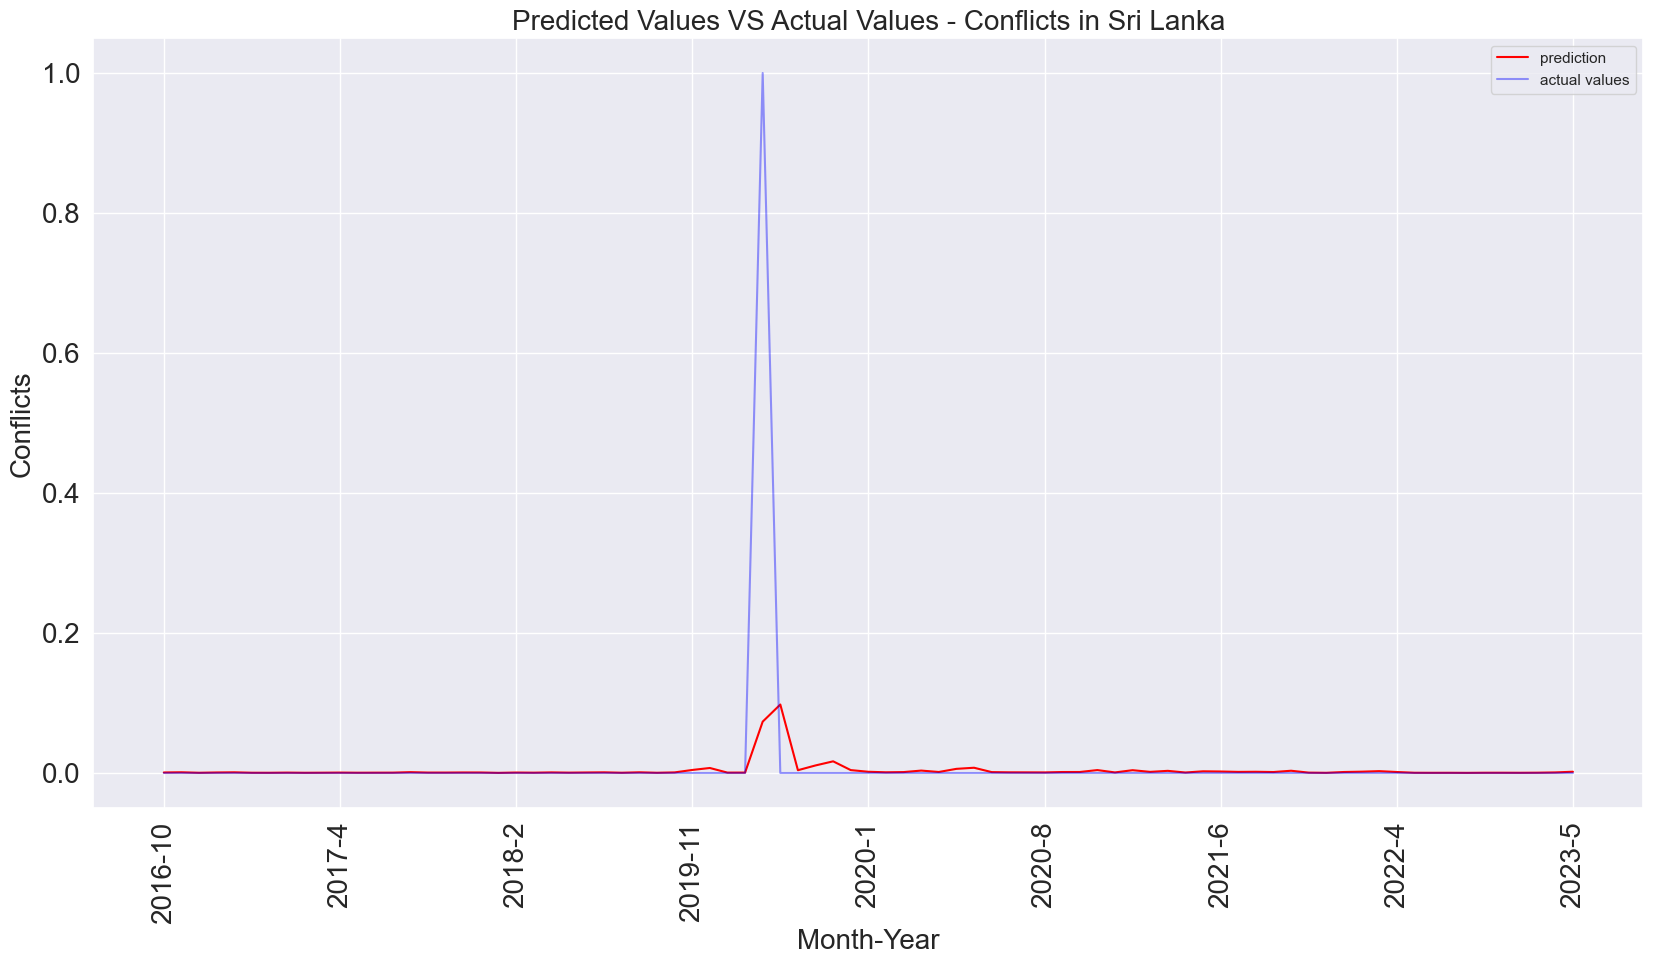

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/176966479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country['armedconf'] = df_final['armedconf'].astype(int)
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[X_train.columns]=X_train
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_89349/2045232148.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

3/3 [==============================] - 0s 15ms/step


2023-06-20 09:51:24.903668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-20 09:51:24.953133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Nigeria - RMSE: 0.5041484598093273


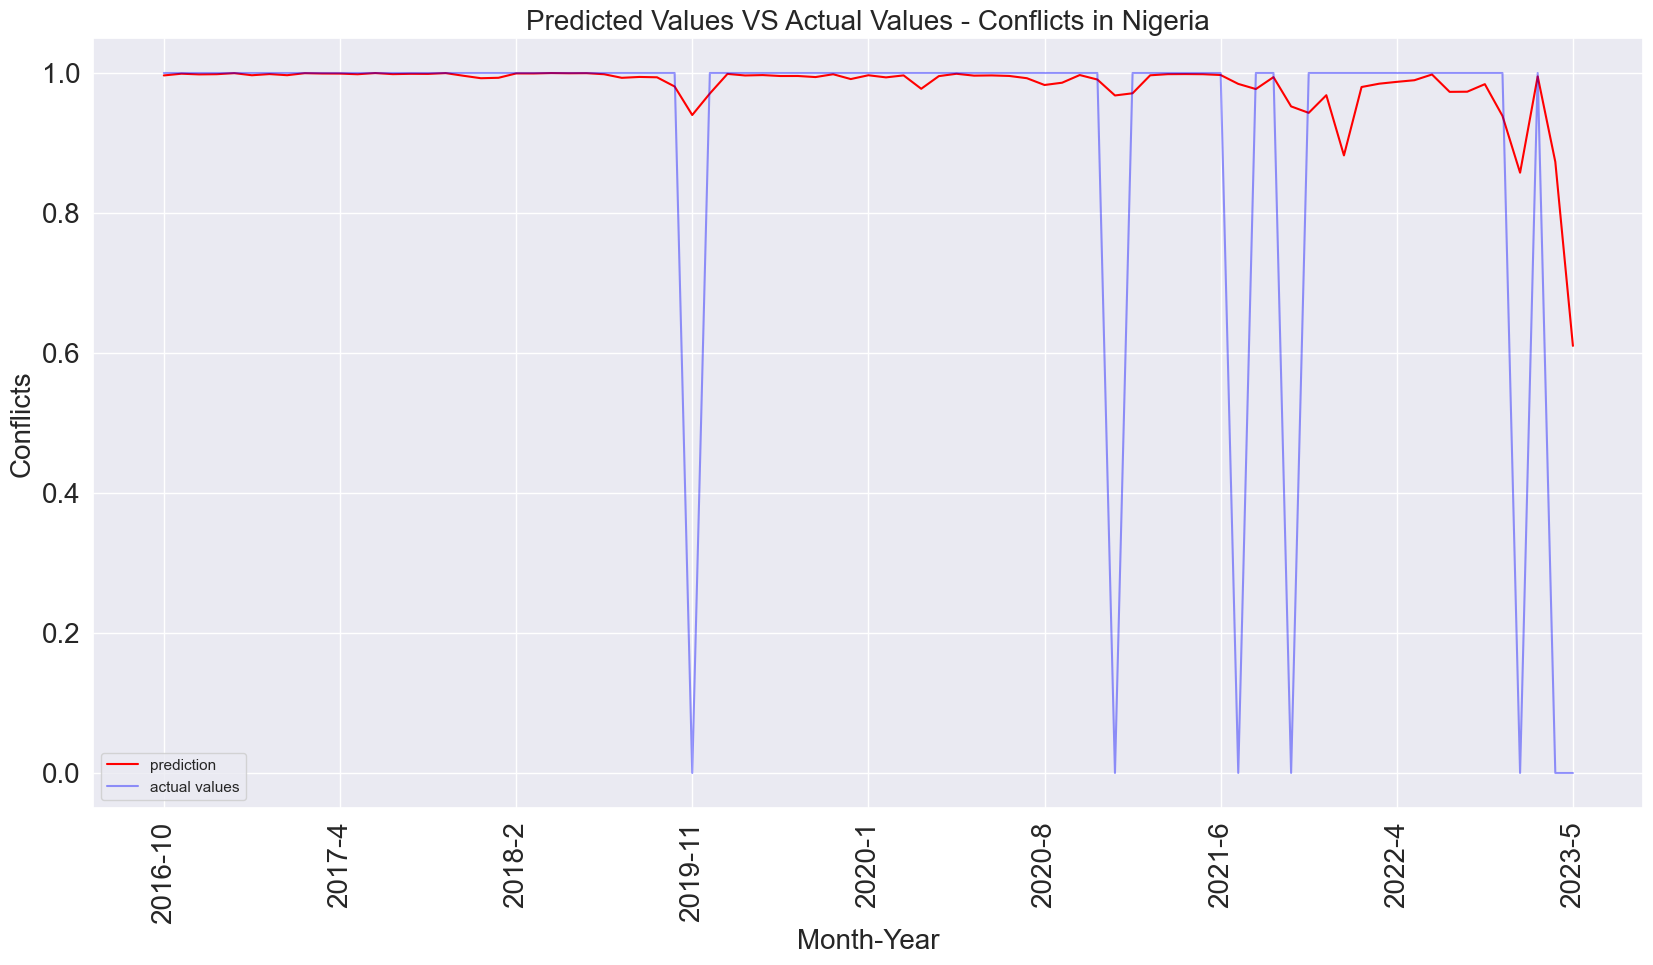

In [114]:
for i in range(len(top_10_country_names)): 
    # obtain one country's data 
    country=df_final[df_final['country']==top_10_country_names[i]]
    country['armedconf'] = df_final['armedconf'].astype(int)
    # train test split, normalization and reshape the data
    x_train, x_test, y_train, y_test = normalization_train_test_split(country)
    # model 
    model = Sequential()
    model.add(LSTM(60,input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    # fit network
    history = model.fit(x_train, y_train, epochs=50, batch_size=30,  verbose=0, shuffle=False)
    # make a prediction
    y_test_pre = model.predict(x_test)
    #RMSE
    rmse = np.sqrt(RMSE(y_test[:-1], [i[0] for i in y_test_pre][1:]))
    print('{} - RMSE: {}'.format(top_10_country_names[i],rmse))
    #create new dataframe for plot 
    pa = pd.DataFrame()
    pa['Month_Year'] = country.iloc[len(country)-len(y_test_pre)+1:]['year'].astype(str) + '-' + country.iloc[len(country)-len(y_test_pre)+1:]['month'].astype(str)
    pa['Prediction'] = [i[0] for i in y_test_pre][1:] 
    pa['Actual Values'] = list(y_test[1:])

    plt.figure(figsize=(20,10))
    pa.groupby('Month_Year')['Prediction'].sum().plot(kind='line', label='prediction', color='red', alpha=1)
    pa.groupby("Month_Year")['Actual Values'].sum().plot(kind='line', label='actual values', color='blue', alpha=0.4)
    plt.xticks(rotation=90,size=20)
    plt.yticks(size=20)

    plt.ylabel('Conflicts',fontsize=20)
    plt.xlabel('Month-Year',fontsize=20)
    plt.title('Predicted Values VS Actual Values - Conflicts in {}'.format(top_10_country_names[i]),fontsize=20)
    plt.legend()
    plt.show()